In [ ]:
pip install -U git+https://github.com/MIROptics/ECC2025.git

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from qiskit import QuantumCircuit
from qiskit.primitives import Estimator
from qiskit.quantum_info import SparsePauliOp 
from qiskit.circuit import ParameterVector 
from sklearn.svm import SVC 
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler 
from sklearn.decomposition import PCA
from ECC2025.testing import test_7a, test_7b, test_7c

Uno de los campos donde Chile ha destacado en la última década es la __astronomía__. El norte de Chile, dotado de cielos idóneos para realizar astronomía observacional, alberga algunos de los telescopios más importantes del mundo, tales como ALMA, Paranal, Gemini, Las Campanas, Tololo y SOAR. Estos telescopios generan vastos volúmenes de datos sobre objetos astronómicos, los cuales deben ser procesados para su estudio. Debido a esto, el estudio y desarrollo de herramientas númericas para procesar datos astronómicos es de gran relevancia para Chile. En este desafío veremos que la computación cuántica puede aplicarse a este ámbito.

Una galaxia, en general, es un conjunto de estrellas, polvo y gas unidos gravitacionalmente en una estructura más o menos definida. Estas pueden clasificarse por su morfología en elípticas, espirales e irregulares, tal como resume la __secuencia de Hubble__.

![hubble](https://upload.wikimedia.org/wikipedia/commons/8/8a/Hubble_sequence_photo.png)

La clasificación de galaxias es un campo activo de estudio, donde el uso de herramientas de inteligencia artificial se ha vuelto extremadamente común [Dominguez-Sanchez et al. (2018)](https://academic.oup.com/mnras/article/476/3/3661/4848300); [Barchi et al. (2019)](https://www.sciencedirect.com/science/article/abs/pii/S2213133719300757?via%3Dihub). En este desafío, utilizaremos una máquina cuántica de soporte vectorial para clasificar galaxias elípticas y espirales. Utilizaremos datos públicamente disponibles en Galaxy Zoo, un proyecto online que invita a ayudar a clasificar más de un millon de galaxias. Las características de las galaxias en este conjunto de datos se recopilan a partir de las métricas morfológicas proporcionadas en el siguiente catálogo. Se incluyen un total de 6 características independientes de la distacia para análisis: la concentración $C$, la asimetría $A$, la suavidad $S$, el segundo momento de gradiente $G2$, la entropía de información de Shannon $H$ y el área de la elipse petrosiana dividida por el área de la función de dispersión puntual $K$.

In [3]:
data = pd.read_csv("https://raw.githubusercontent.com/MIROptics/ECC2025/refs/heads/master/desafios/data/galaxia_mod.csv",  low_memory=False )
data = data[['spiral=1 elliptical=0','C','A','S','G2', 'H', 'K']]
data = data.drop_duplicates() # Eliminar Duplicados
data.head(10)

,spiral=1 elliptical=0,C,A,S,G2,H,K
0,1,0.377586,0.820991,0.872967,1.646847,0.753667,18.523393
1,1,0.481648,0.918934,0.811223,1.558076,0.695033,9.387313
2,0,0.468097,0.896377,0.890470,1.273454,0.633161,6.437712
3,1,0.324003,0.763444,0.852662,1.793868,0.848901,18.569745
4,0,0.464912,0.868397,0.849914,0.667866,0.511509,9.625444
5,0,0.603811,0.812854,0.349620,0.530258,0.497737,36.433943
6,1,0.336279,0.877052,0.880690,1.617068,0.711718,9.599356
7,1,0.373332,0.718354,0.777832,1.151588,0.653070,22.308795
8,1,0.382949,0.849003,0.821886,1.231995,0.612244,9.031537
9,1,0.485651,0.883585,0.804968,1.567016,0.687035,8.545871


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 215681 entries, 0 to 215684
Data columns (total 7 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   spiral=1 elliptical=0  215681 non-null  int64  
 1   C                      215681 non-null  float64
 2   A                      215681 non-null  float64
 3   S                      215681 non-null  float64
 4   G2                     215681 non-null  float64
 5   H                      215681 non-null  float64
 6   K                      215681 non-null  float64
dtypes: float64(6), int64(1)
memory usage: 13.2 MB


Debido a la gran cantidad de datos, realizaremos una muestra estratificada para preservar la proporción entre galaxias espirales y elípticas.

In [5]:
# Tamaño de la muestra: 0.1% del dataset
sample_size = 0.001

# Dividir en una muestra estratificada
df_sample, _ = train_test_split(
                                data,
                                stratify=data['spiral=1 elliptical=0'],  # Variable para estratificación
                                test_size=(1 - sample_size),  # 99.9% quedará fuera de la muestra
                                random_state=42  # Semilla para reproducibilidad
                                )

In [6]:
df_sample.info()

<class 'pandas.core.frame.DataFrame'>
Index: 215 entries, 135333 to 142807
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   spiral=1 elliptical=0  215 non-null    int64  
 1   C                      215 non-null    float64
 2   A                      215 non-null    float64
 3   S                      215 non-null    float64
 4   G2                     215 non-null    float64
 5   H                      215 non-null    float64
 6   K                      215 non-null    float64
dtypes: float64(6), int64(1)
memory usage: 13.4 KB


In [7]:
#Separamos el target de resto del data
X=  df_sample.drop(columns=['spiral=1 elliptical=0'])
y=  df_sample['spiral=1 elliptical=0']

Contamos con 6 características, pero las reduciremos a 4 para simplificar el entrenamiento de nuestra máquina cuántica de soporte vectorial, empleando un análisis de componentes principales.

In [8]:
# Normalizar las características (es recomendable para PCA y SVM)
scaler = MinMaxScaler()
X_normalizado = scaler.fit_transform(X)

# Inicializar el PCA y retener un 96% de la varianza
pca = PCA(n_components=0.96)
X_pca = pca.fit_transform(X_normalizado)

# Mostrar la varianza explicada
print("Varianza explicada por cada componente:", pca.explained_variance_ratio_)

Varianza explicada por cada componente: [0.68265503 0.128477   0.08443644 0.06897231]


Ahora dividimos los datos en conjuntos de entrenamiento y prueba.

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=27)

Primero entrenaremos una máquina de soporte vectorial clásica para utilizarla como referencia frente a la cuántica.

In [10]:
# Inicializar el modelo SVM
svm = SVC(kernel='linear')  # Puedes elegir otro kernel si lo deseas

# Entrenar el modelo
svm.fit(X_train, y_train)

# Predecir en el conjunto de prueba
y_pred = svm.predict(X_test)

# Calcular la precisión
accuracy = accuracy_score(y_test, y_pred)
print(f"Precisión del modelo SVM después de PCA: {accuracy}")

Precisión del modelo SVM después de PCA: 0.9302325581395349


Procederemos a diseñar nuestra máquina cuántica de soporte vectorial.

__Desafio 1:__ Diseñe un circuito cuántico que funcione como el mapeo de características de datos. Este circuito debe incluir 4 qubits, 4 parámetros y tener una profundidad inferior a 20.

In [11]:
# construimos circuito parametrico
def optimized_quantum_circuit():

    # Se construye un circuito cuántico de 4 qubits
    qc_dato = QuantumCircuit(4)

    # Definimos un conjunto de parámetros que serán ajustados
    theta = ParameterVector('θ', 4)

    ####

    ####
    
    return qc_dato

In [12]:
test_7a(optimized_quantum_circuit) 

Tu circuito es correcto


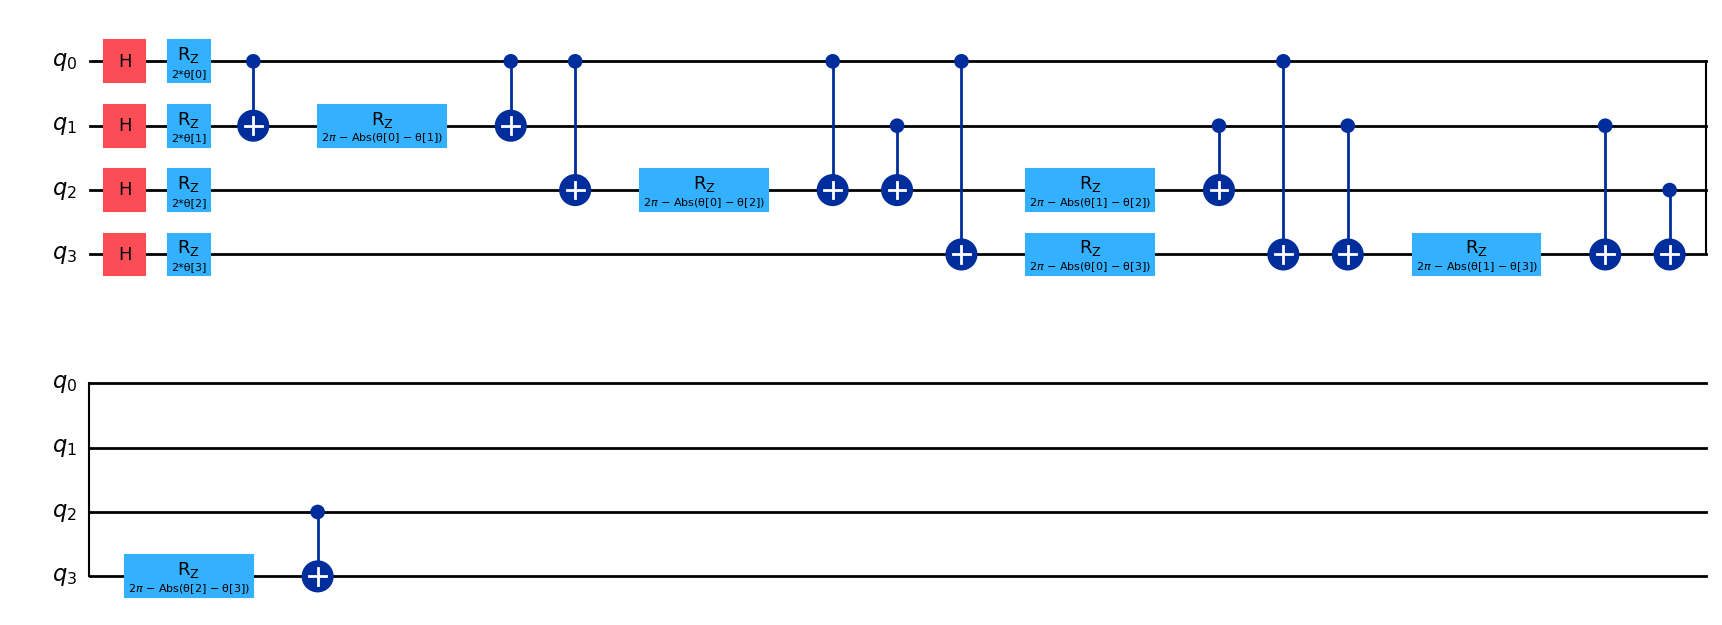

In [13]:
qc_optimizado = optimized_quantum_circuit()
qc_optimizado.draw('mpl')

La evaluación de los elementos del kernel requiere calcular la fidelidad entre dos estados cuánticos $|\psi\rangle$ y  $|\phi\rangle$, definida como:
$$  F(|\psi\rangle,|\phi\rangle) =  | \langle \psi | \phi\rangle |^2. $$
Una forma de realizar este cálculo es mediante el __swap test__. Este consiste en codificar ambos estados en conjuntos independientes de registros cuánticos, y en utilizar un qubit auxiliar y una secuacias de puertas SWAP controladas, tal como muestra la siguiente figura. Esto permite mapear la fidelidad $F$ entre ambos estados al qubit auxiliar, información que puede ser extraida por una medida del observable $\sigma_z$.

![](https://raw.githubusercontent.com/MIROptics/ECC2025/refs/heads/master/desafios/img/ECC2025_swap_test.png?raw=true)

__Desafio:__ Complete la siguiente función para evaluar un elemento del kernel cuántico utilizando el método del swap test.

In [ ]:
# contruimos un circuito de swap test
def kernel_element( dato_1, dato_2,
                    backend=Estimator(options={'seed':1}), shots=1000  ):

    value = 0 # resultado por defecto
    # Se define un circuito cuántico de 9 qubits
    qc_swap_test = QuantumCircuit( 9 )

    # Preparamos los circuitos cuánticos para los datos

    # Combinamos los circuitos cuánticos de los dos datos a comparar

    # Se agrega la puerta Hadamard al qubit auxiliar

    # Aplicación de las puertas Controlled-Swap (CSWAP) entre qubits

    # Aplicamos nuevamente la puerta Hadamard al qubit auxiliar

    # Ejecutamos el circuito cuántico y obtenemos los resultados
    job= backend.run(qc_swap_test,SparsePauliOp(['IIIIIIIIZ'],[1]),shots=shots)
    value=job.result().values[0]

    return qc_swap_test, value

1.0000000001628446


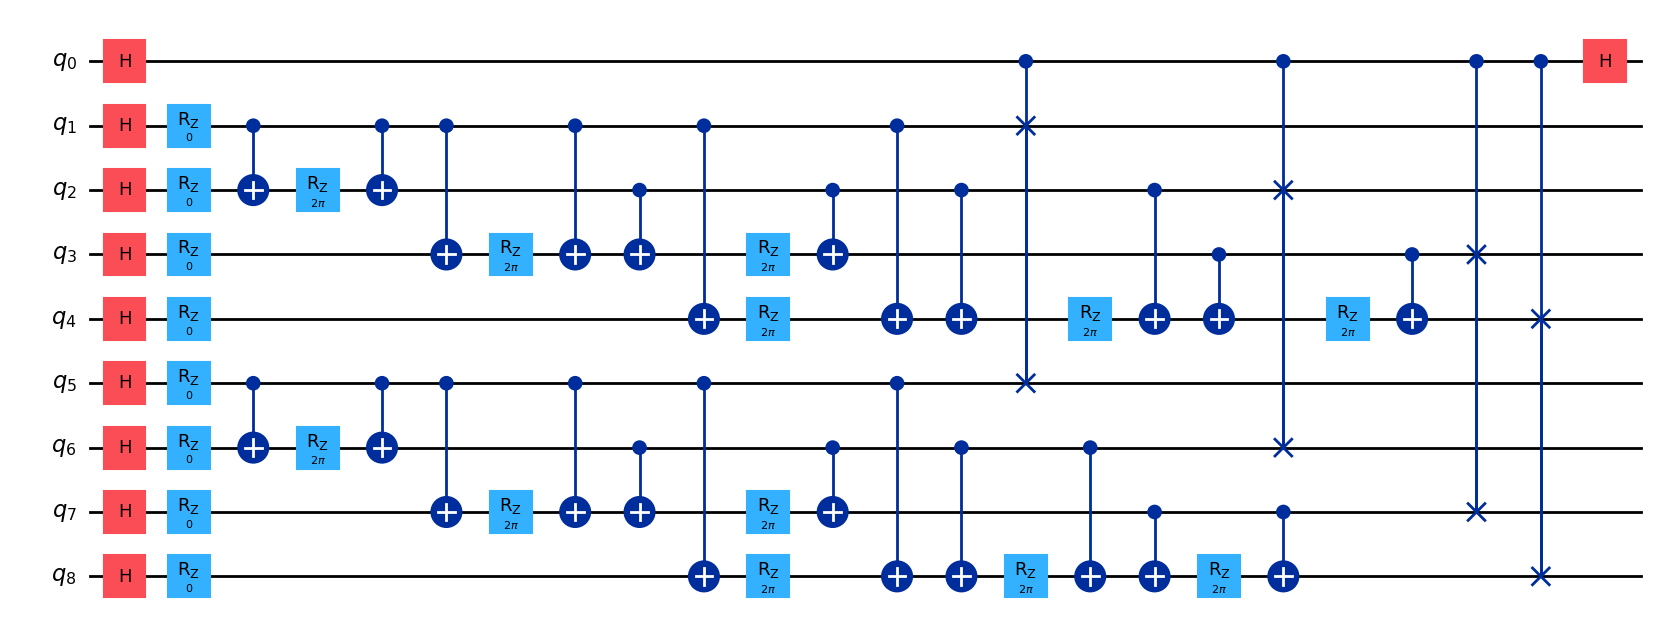

In [15]:
qc_swap_test, value = kernel_element( np.zeros(4), np.zeros(4) )
print( value )
qc_swap_test.draw('mpl')

In [ ]:
test_7b( kernel_element )

__Desafio 3:__ La siguiente función construye el kernel cuántico y realiza el entrenamiento de la SVM. Su objetivo es alcanzar una fidelidad superior al 90% en el entrenamiento. Si la fidelidad obtenida es menor, regrese al Desafío 1 e intente un mapeo de características diferente. Es decir, si la fidelidad no es suficiente, debe volver al desafio 1 y modificarlo.

In [ ]:
# construimos kernel cuantico
def Quantum_Kernel( X_train, X_test=None,
                    backend=Estimator(options={'seed':1}), shots=1000 ):
    """
    X_train : vector bidimensional para entrenar
    X_test  : vector bidimensional para testear
    K_q     : Kernel cuantico
    backend : simulador o computador cuantico
    shots   : numero de shots
    """

    if X_test is None:
        X_test = X_train
    X_train = np.array(X_train)
    X_test  = np.array(X_test)

    # Inicializar la matriz de similitudes cuánticas
    K_q = np.zeros(( X_test.shape[0], X_train.shape[0]))

    values = []
    for x_test in X_test:
        for x_train in X_train:
            # Calcular el valor del kernel cuántico (swap test) entre los datos
            values.append( kernel_element( x_train, x_test,
                                            backend=backend, shots=shots )[1]  )

    l = 0
    for j, x_test in enumerate( X_test ):
        for k, x_train in enumerate( X_train):
            K_q[j,k] = values[l]
            l += 1

    return K_q

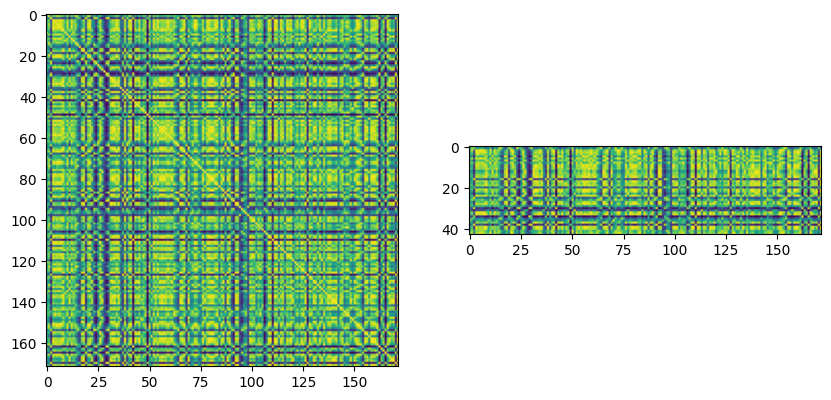

In [18]:
Kq_train = Quantum_Kernel( X_train )
Kq_test  = Quantum_Kernel( X_train, X_test )

# Visualización de las matrices de similitudes
fig, ax = plt.subplots( 1, 2, figsize=(10,5) )
ax[0].imshow( Kq_train )
ax[1].imshow( Kq_test )

In [ ]:
test_7c( Kq_train, y_train, Kq_test, y_test ) 